In [2]:
import jax
import jax.numpy as jnp
from opgp import build_solve, build_predict_scalar
import matplotlib.pyplot as plt

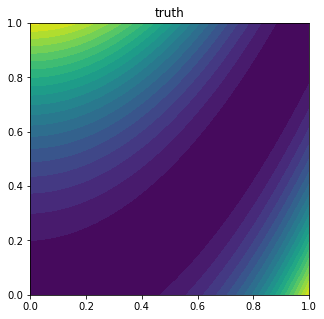

In [3]:
def rosenbrock2d(x, a=1, b=100):
    return (a - x[0])**2 + b*(x[1] - x[0]**2)**2

f_truth = rosenbrock2d
ngrid = 100
xlims = (0,1)
ylims = (0,1)
xtest = jnp.stack(jnp.meshgrid(jnp.linspace(*xlims, ngrid), jnp.linspace(*ylims, ngrid)), axis=-1).reshape(-1, 2)
ytest = jax.vmap(f_truth)(xtest)
plt.figure(figsize=(5,5))
plt.tricontourf(*xtest.T, ytest, levels=20)
plt.title("truth");

In [4]:
def rbf(x1, x2, lengthscale=1.0):
    return jnp.exp(-0.5 * jnp.sum((x1-x2)**2) / lengthscale**2)

In [7]:
def experiment(k, operators, x=jnp.array([[0.2,0.8], [0.8,0.2]])):
    observations = {key: jax.vmap(op(f_truth))(x) for key, op in operators.items()}
    solve = build_solve(k, operators)
    alphas = solve(x, observations)
    f_sol = build_predict_scalar(k, operators, x, alphas)
    return f_sol

observed $f$ MAE 25.31565820033325 MSE 778.0906901687326
observed $f,\,\nabla f$ MAE 9.429567808327473 MSE 156.68911066366906
observed $f,\,\nabla f,Hess(f)$ MAE 2.685769665367487 MSE 19.362981947635305


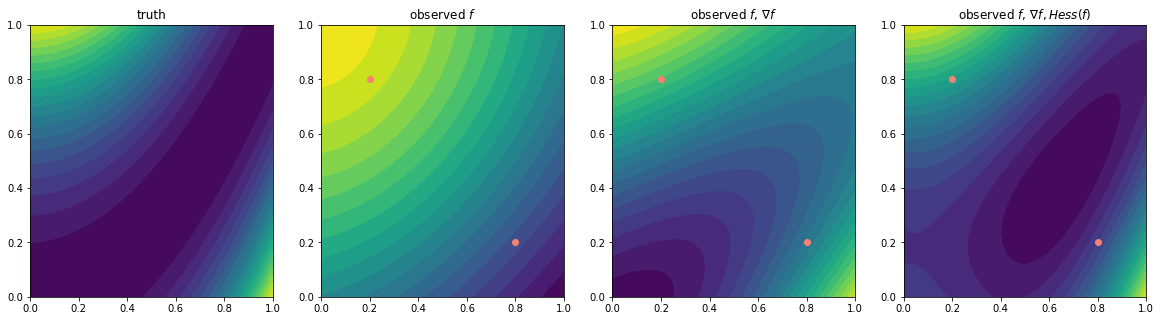

In [11]:
combs = {
    r"observed $f$": {"identity": lambda f: f},
    r"observed $f,\,\nabla f$": {"identity": lambda f: f, "gradient": jax.grad},
    r"observed $f,\,\nabla f,Hess(f)$": {"identity": lambda f: f, "gradient": jax.grad,"hessian": jax.hessian},
#     r"observed $f,Hess(f)$": {"identity": lambda f: f, "hessian": jax.hessian},
#     r"observed $Hess(f)$": {"hessian": jax.hessian},
}
fig, axs = plt.subplots(ncols=1+len(combs), figsize=[5*(1+len(combs)),5])
y_true = jax.vmap(f_truth)(xtest)
axs[0].tricontourf(*xtest.T, y_true, levels=20)
axs[0].set_title("truth")
for ax, (title, comb) in zip(axs[1:], combs.items()):
    # x = jnp.array([[0.2,0.8], [0.8,0.2], [0.8,0.8]])
    x = jnp.array([[0.2,0.8], [0.8,0.2]])
    f_sol = experiment(rbf, comb, x=x)
    y_preds = jax.vmap(f_sol)(xtest)
    mae = jnp.mean(jnp.abs(y_true - y_preds))
    mse = jnp.mean((y_true - y_preds)**2)
    print(title, "MAE", mae, "MSE", mse)
    ax.tricontourf(*xtest.T, y_preds, levels=20)
    ax.scatter(*x.T, c="salmon")
    ax.set_title(title);

# prepare for inkscape

In [12]:
# precompute reconstructions
f = {title: experiment(rbf, comb, x=x) for title, comb in combs.items()}

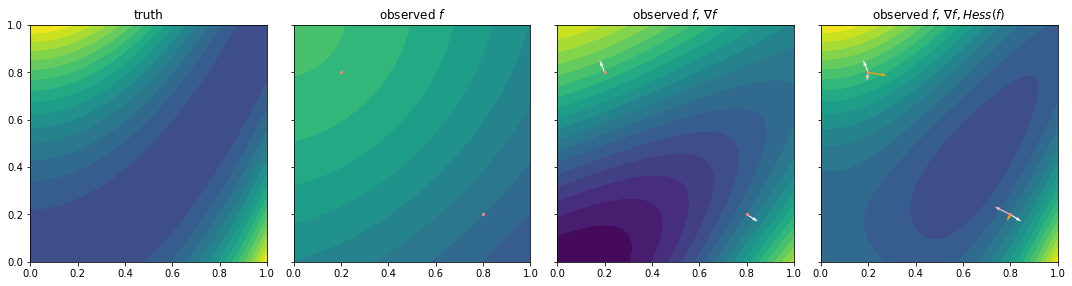

In [18]:
fig, axs = plt.subplots(ncols=1+len(combs), figsize=[5*(len(combs)),5])
levels = jnp.linspace(
    min([jax.vmap(f_truth)(xtest).min()] + [jax.vmap(f_sol)(xtest).min() for _, f_sol in f.items()]),
    max([jax.vmap(f_truth)(xtest).max()] + [jax.vmap(f_sol)(xtest).max() for _, f_sol in f.items()]), 
    num=20
)
axs[0].tricontourf(*xtest.T, jax.vmap(f_truth)(xtest), levels=levels)
axs[0].set_title("truth")
axs[0].set_aspect(1)
for ax, (title, comb) in zip(axs[1:], combs.items()):
    x = jnp.array([[0.2,0.8], [0.8,0.2]])
    f_sol = f[title]
    ax.tricontourf(*xtest.T, jax.vmap(f_sol)(xtest), levels=levels)
    if "hessian" in comb: 
        h = jax.vmap(jax.hessian(f_truth))(x)
        eigvals, eigvecs = jax.vmap(jnp.linalg.eigh)(h)
        λ1, v1 = eigvals[:,0], eigvecs[:,0]
        λ2, v2 = eigvals[:,1], eigvecs[:,1]
        scale = lambda λ, v: v * (jnp.sqrt(jnp.abs(λ)) * jnp.sign(λ))
        scaled1 = jax.vmap(scale)(λ1, v1)
        scaled2 = jax.vmap(scale)(λ2, v2)
        ax.quiver(*x.T, *scaled1.T, width=0.005, color='orange', alpha=0.95)
        ax.quiver(*x.T, *scaled2.T, width=0.005, color='pink', alpha=0.95)
    if "gradient" in comb:
        ax.quiver(*x.T, *jax.vmap(jax.grad(f_truth))(x).T, width=0.005, color='white', alpha=0.95)
    if "identity" in comb:
        ax.scatter(*x.T, c="salmon", s=5)
    ax.set_aspect(1)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_title(title);
plt.tight_layout()

In [14]:
fig.savefig("hessian-twopoints-contourf.pdf")